In [62]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
max = 4.0
step = 0.02

states = np.arange(0, max, step)
actions = np.arange(0, max, step)

smooth = 40
T = 4
Q = np.zeros([smooth, T, round(max / step), round(max / step)])
epsilon = 0.15
om_q = 0.55
om_mu = 0.85
gamma = 0.2
rho = 0.95
C = 3

mu = np.ones([smooth, T, len(actions)])
for p in range(smooth):
    for t in range(T):
        for i in range(len(actions)):
            mu[p, t, i] = mu[p, t, i] / len(actions)

# idk about this factor (gamma in the pseudocode), a value was not mentioned in their description
discount = 0.95

# given white noise process with specific supports and probabilities
supp_W = [0.9, 1.3]
pmf_W = [0.75, 0.25]

# calculate expectation of white noise process 
exp_W_gamma = 0
for i in range(len(supp_W)):
    exp_W_gamma += np.pow(supp_W[i], gamma) * pmf_W[i]

# calculate rho * expectation [W ^ gamma]
pEWgamma = rho * exp_W_gamma

# white noise with two outcomes with probabilities established above
def W ():
    return np.random.choice(supp_W, p = pmf_W)

# given state/action (by index) and mean field investment
# return through G(mu, W()) * a (amount invested)
# the new state (rounded)
# and using formula for utility calculate reward
def env (state, action, mu):
    consump = states[state] - actions[action]
    wealth = actions[action] * W() * C / (pEWgamma * (1 + (C - 1) * np.pow(mu, 3)))
    newState = round(wealth / step)
    utility = np.pow(consump, gamma) / gamma
    return { 'x': newState, 'u': utility }

# rho calculator, given we are on the kth episode and
# have visited the specific state/action/time pair count_txa times

def rhosCalc(count_txa, k):
    '''does this have a counter incrementing?'''
    rhoQ = 1 / np.pow(1 + count_txa, om_q)
    rhoMu = 1 / np.pow(2 + k, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }

# eps-greedy policy, takes in 1d array of Q matrix specified by state and time, and state (index)
# if Unif[0, 1] > epsilon, choose argmax on 1d array of Q matrix, limited by state
# if Unif[0, 1] < epsilon, choose random action, limited by state (unif distribution)
def epsAction (Q_x, state):
    if np.random.random() > epsilon:
        maxim = np.max(Q_x[:state + 1])
        ind = []
        for i in range(0, state + 1):
            if maxim == Q_x[i]:
                ind.append(i)
        return ind[np.random.randint(0, len(ind))]
    else:
        return np.random.choice(list(range(state + 1)))


num_episodes = 200000
jump = round(num_episodes / 100)

mu_k = []
for t in range(T):
    mu_k.append([])
    for p in range(smooth):
        mu_k[t].append([])

for p in range(smooth):

    # initialize count for finding rho_Q (learning rate)
    count_txa = np.zeros([T, len(states), len(actions)])

    # Learning loop
    for k in range(num_episodes):

        # Sample initial state 
        x_idx = np.random.choice(list(range(0, round(1 / step) + 1)))
    
        # Episode loop over time periods
        for t in range(T):
        
            # Ensure valid state
            if x_idx >= len(states) or x_idx < 0:
                break
            
            # Current Q values at t
            Q_xt = Q[p, t, x_idx, :]
        
            # Select action
            a_idx = epsAction(Q_xt, x_idx)
        
            # Skip if action exceeds state 
            if a_idx > x_idx:
                print("act > stat")
                a_idx = x_idx  #Invest everything instead of breaking
        
            # Get mean field investment at current time
            mu_t = np.dot(mu[p, t], actions)
        
            #call to environment
            result = env(x_idx, a_idx, mu_t)
            next_x_idx = result['x']
            reward = result['u']
        
            # Check next state is within the state space
            next_x_idx = np.min([np.max([next_x_idx, 0]), len(states) - 1])
        
            # Calculate target
            if t < T - 1:
                if next_x_idx > 0:
                    max_next_Q = discount * np.max(Q[p, t + 1, next_x_idx, :next_x_idx + 1])
                else:
                    max_next_Q = discount * Q[p, t + 1, 0, 0]
                td_target = reward + max_next_Q
            else:
                #end state
                td_target = reward + rho * np.pow(states[next_x_idx], gamma) / gamma

            # target for mean field
            a_target = np.zeros(len(actions))
            a_target[a_idx] = 1
        
            # Update count for learning rate
            count_txa[t, x_idx, a_idx] += 1
        
            # Calculate learning rates
            rhos = rhosCalc(count_txa[t, x_idx, a_idx], k)
            rho_Q = rhos['q']
            rho_Mu = rhos['mu']
        
            # Q-learning update
            Q[p, t, x_idx, a_idx] = Q[p, t, x_idx, a_idx] + rho_Q * (td_target - Q[p, t, x_idx, a_idx])
        
            # Mean field distribution update
            mu[p, t, :] = mu[p, t, :] + rho_Mu * (a_target - mu[p, t, :])

            # Move to next state
            x_idx = next_x_idx

            if (k + 1) % jump == 0:
                mu_k[t][p].append(np.dot(mu[p][t], actions))

# check state/action space
# simplify mean field action

KeyboardInterrupt: 

In [ ]:
theoretical = np.linalg.solve([])

1.5715047707024394


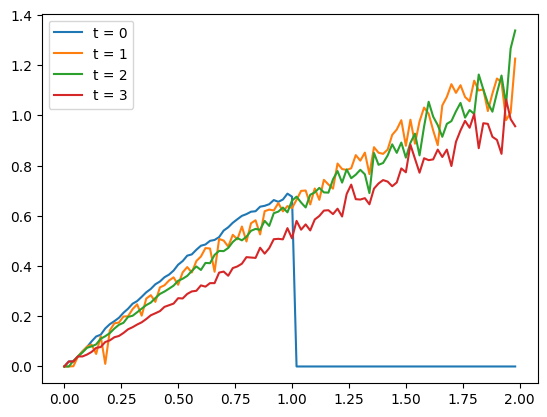

In [64]:
# argmaxxing to find optimal policy for each state
# and plotting to see trend
optimal = []
for t in range(T):
    optimal.append([])
    for x in range(round(max / step)):
        optimal[t].append([])
        for p in range(smooth):
            optimal[t][x].append(actions[np.argmax(Q[p, t, x, :])])

OPTIMAL = []
for t in range(T):
    OPTIMAL.append([])
    for x in range(round(max / step)):
        OPTIMAL[t].append(np.mean(optimal[t][x]))

%matplotlib inline

plt.plot(states[:100], OPTIMAL[0][:100])
plt.plot(states[:100], OPTIMAL[1][:100])
plt.plot(states[:100], OPTIMAL[2][:100])
plt.plot(states[:100], OPTIMAL[3][:100])
plt.legend(["t = 0", "t = 1", "t = 2", "t = 3"])

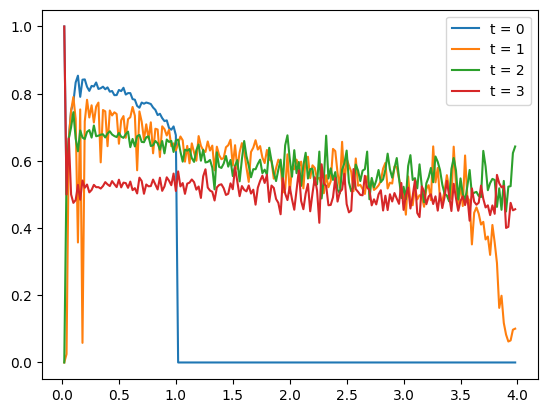

In [71]:
prop = []
for t in range(T):
    prop.append([])
for x in range(1, round(max / step)):
    for t in range(T):
        prop[t].append(OPTIMAL[t][x] / states[x])

%matplotlib inline

plt.plot(states[1:], prop[0])
plt.plot(states[1:], prop[1])
plt.plot(states[1:], prop[2])
plt.plot(states[1:], prop[3])
plt.legend(["t = 0", "t = 1", "t = 2", "t = 3"])

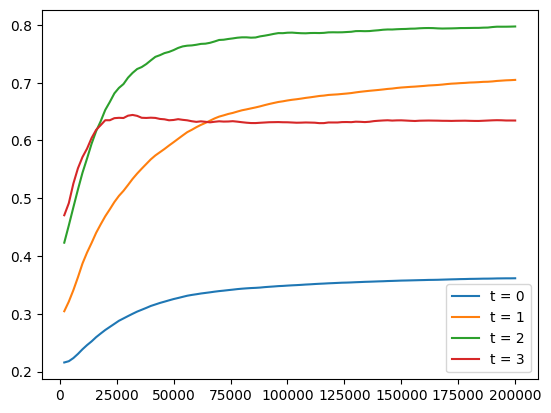

In [66]:
mus = []
for t in range(T):
    mus.append([])
    for i in range(round(num_episodes / jump)):
        sum = 0
        for p in range(smooth):
            sum += mu_k[t][p][i]

        mus[t].append(sum / smooth)


%matplotlib inline

plt.plot(list(range(jump, num_episodes + jump, jump)), mus[0])
plt.plot(list(range(jump, num_episodes + jump, jump)), mus[1])
plt.plot(list(range(jump, num_episodes + jump, jump)), mus[2])
plt.plot(list(range(jump, num_episodes + jump, jump)), mus[3])
#plt.plot(list(range(jump, num_episodes + jump, jump)), mu_k[4])
plt.legend(["t = 0", "t = 1", "t = 2", "t = 3"])